In [6]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import regionprops

In [7]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/'
protein="TNR" #TNR,Agg,WFA,HABP

In [9]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "synapsechannelno":[],
           "Manual vglut spots mask":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        #print(1)
        if "2019" in str(filelist[i]):
            #print(2)
            if ("Pop" in str(filelist[i]))==False:
                #print(3)
                if ("save" in str(filelist[i]))==False:
                    #print(4)
                    if ("spot" in str(filelist[i]))==False:
                        if ("TIFs_analyse copy" in str(filelist[i]))==False:
                            if ("samecellonly" in str(filelist[i]))==False:
                                if ("Silvioanal" in str(filelist[i]))==False:
                            #print(5)
                                    if filelist[i].endswith(".tif"): 
                                    #print(6)
                                        if "\\" in str(filelist[i]):
                                            #print(7)
                                            if (('/').join(filelist[i].split('\\')[:-1])+'\\\\'+filelist[i][:-12].split('\\')[-1] in str(results["filename"]))==False:
                                                print(filelist[i])
                                                results["filename"].append(filelist[i][:-12])
                                                results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                                channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                                                exec(open(channeldir+"/channels.txt").read())
                                                results["ecmchannelno"].append(ecmchannelno)
                                                results["synapsechannelno"].append(synapsechannelno) 
                                        elif (str(filelist[i][:-12]) not in str(results["filename"]))==True:
                                            print(8)
                                            results["filename"].append(filelist[i][:-12])
                                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                            channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                                            exec(open(channeldir+"/channels.txt").read())
                                            results["ecmchannelno"].append(ecmchannelno)
                                            results["synapsechannelno"].append(synapsechannelno)

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_001_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_002_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_004_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_005_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\06_001_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\06_002_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDB

## load random image

Image name: 04_cell3_axon_ExpControl
Experimental condition: TIF_imp


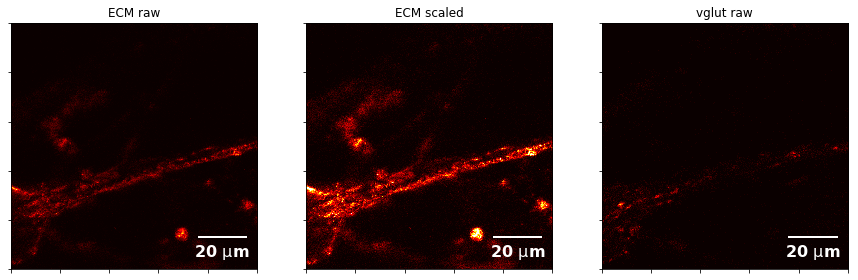

In [10]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]
#autofluorescence_image=pims.open(autofluorescence_image_name)[0]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('vglut raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## load synapse spots

In [11]:
for image in range(0,len(results["filename"])):
    results["Manual vglut spots mask"].append(np.load(results["filename"][image]+'_vglut_spots_mask.npy'))

## calculate mean in each image: inside and outside mask

In [12]:
results["tnr mean in whole image"]=[]
results["tnr mean in vglut spots mask"]=[]
results["tnr mean in dilated vglut spots mask"]=[]
results["tnr mean outside vglut spots mask"]=[]
results["tnr mean outside dilated vglut spots mask"]=[]
results["vglut mean in whole image"]=[]
results["vglut mean in vglut spots mask"]=[]
results["vglut mean in dilated vglut spots mask"]=[]
results["vglut mean outside vglut spots mask"]=[]
results["vglut mean outside dilated vglut spots mask"]=[]

for i in range(0,len(results["filename"])):
#for i in range(2,30):
    print(i)
    ecm_channel_no=results["ecmchannelno"][i]
    ecm_image_name=results["filename"][i]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    synapse_channel_no=results["synapsechannelno"][i]
    synapse_image_name=results["filename"][i]+" Ch"+str(synapse_channel_no)+" {0}.tif"
    synapse_image=pims.open(synapse_image_name)[0]
    
    spots_mask=results["Manual vglut spots mask"][i]
    if len(spots_mask.shape)>0:
        spots_mask_dilated=ndi.binary_dilation(spots_mask,iterations=3)
    
    #after bg subtraction
    ecm_bgsub=np.array(deepcopy(ecm_image))
    ecm_bgsub=np.divide(ecm_bgsub,255)
    bg_ecm=np.mean(ndi.median_filter(ecm_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_bgsub,size=5))
    ecm_bgsub=np.subtract(ecm_bgsub,bg_ecm)
    ecm_bgsub[ecm_bgsub<0]=0

    synapse_bgsub=np.array(deepcopy(synapse_image))
    synapse_bgsub=np.divide(synapse_bgsub,255)
    bg_synapse=np.mean(ndi.median_filter(synapse_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_bgsub,size=5))
    synapse_bgsub=np.subtract(synapse_bgsub,bg_synapse)
    synapse_bgsub[synapse_bgsub<0]=0


    results["vglut mean in whole image"].append(synapse_bgsub.mean())
    results["tnr mean in whole image"].append(ecm_bgsub.mean())
    if len(spots_mask.shape)>0:
        print('bigger than 0')
        if np.isnan(spots_mask.any())==False:
            print('good spots')
            if np.sum(spots_mask)>0:
                results["tnr mean in vglut spots mask"].append(ecm_bgsub[spots_mask].mean())
                results["tnr mean in dilated vglut spots mask"].append(ecm_bgsub[spots_mask_dilated].mean())
                results["tnr mean outside vglut spots mask"].append(ecm_bgsub[~spots_mask].mean())
                results["tnr mean outside dilated vglut spots mask"].append(ecm_bgsub[~spots_mask_dilated].mean())
                results["vglut mean in vglut spots mask"].append(synapse_bgsub[spots_mask].mean())
                results["vglut mean in dilated vglut spots mask"].append(synapse_bgsub[spots_mask_dilated].mean())
                results["vglut mean outside vglut spots mask"].append(synapse_bgsub[~spots_mask].mean())
                results["vglut mean outside dilated vglut spots mask"].append(synapse_bgsub[~spots_mask_dilated].mean())
            else:
                print('bad spots')
                results["tnr mean in vglut spots mask"].append(np.nan)
                results["tnr mean in dilated vglut spots mask"].append(np.nan)
                results["tnr mean outside vglut spots mask"].append(np.nan)
                results["tnr mean outside dilated vglut spots mask"].append(np.nan)
                results["vglut mean in vglut spots mask"].append(np.nan)
                results["vglut mean in dilated vglut spots mask"].append(np.nan)
                results["vglut mean outside vglut spots mask"].append(np.nan)
                results["vglut mean outside dilated vglut spots mask"].append(np.nan)
        else:
            print('bad spots')
            results["tnr mean in vglut spots mask"].append(np.nan)
            results["tnr mean in dilated vglut spots mask"].append(np.nan)
            results["tnr mean outside vglut spots mask"].append(np.nan)
            results["tnr mean outside dilated vglut spots mask"].append(np.nan)
            results["vglut mean in vglut spots mask"].append(np.nan)
            results["vglut mean in dilated vglut spots mask"].append(np.nan)
            results["vglut mean outside vglut spots mask"].append(np.nan)
            results["vglut mean outside dilated vglut spots mask"].append(np.nan)
    else:
        print('bad bad spots')
        results["tnr mean in vglut spots mask"].append(np.nan)
        results["tnr mean in dilated vglut spots mask"].append(np.nan)
        results["tnr mean outside vglut spots mask"].append(np.nan)
        results["tnr mean outside dilated vglut spots mask"].append(np.nan)
        results["vglut mean in vglut spots mask"].append(np.nan)
        results["vglut mean in dilated vglut spots mask"].append(np.nan)
        results["vglut mean outside vglut spots mask"].append(np.nan)
        results["vglut mean outside dilated vglut spots mask"].append(np.nan)
    
    
    

0
bigger than 0
good spots
1
bigger than 0
good spots
2
bigger than 0
good spots
3
bigger than 0
good spots
4
bigger than 0
good spots
5
bigger than 0
good spots
6
bigger than 0
good spots
7
bigger than 0
good spots
8
bigger than 0
good spots
9
bigger than 0
good spots
10
bigger than 0
good spots
11
bigger than 0
good spots
12
bigger than 0
good spots
13
bigger than 0
good spots
14
bigger than 0
good spots
15
bigger than 0
good spots
16
bigger than 0
good spots
17
bigger than 0
good spots
18
bigger than 0
good spots
19
bigger than 0
good spots
20
bigger than 0
good spots
21
bigger than 0
good spots
22
bigger than 0
good spots
23
bigger than 0
good spots
24
bigger than 0
good spots
25
bigger than 0
good spots
26
bigger than 0
good spots
27
bigger than 0
good spots
28
bigger than 0
good spots
29
bigger than 0
good spots
30
bigger than 0
good spots
31
bigger than 0
good spots
32
bigger than 0
good spots
33
bigger than 0
good spots
34
bigger than 0
good spots
35
bigger than 0
good spots
36

## Dataframe

In [13]:
df=pd.DataFrame(results)

## Add meaningful columns to the dataframe

In [14]:
#make df, which also contains column names for plotting (drug, condition)
df['Time']='None'
df.loc[df["filename"].str.contains('12hr'), 'Time'] = '12hrs'
df.loc[df['filename'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df.loc[df['filename'].str.contains('Unblocked'), 'Time'] = 'Unblocked Control'

df.loc[df['filename'].str.contains('Bic'), 'Drug'] = 'Bic'
df.loc[df['filename'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['filename'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
df.loc[df['filename'].str.contains('Unblocked'), 'Drug'] = 'DMSO'

#nicely written treatment condition for plotting
df['Condition']='None'
df.loc[df['filename'].str.contains('12hr_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['filename'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['filename'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['filename'].str.contains('12hr_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['filename'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
#df.loc[df['filename'].str.contains('Control'), 'Condition'] = 'Unblocked Control'
df.loc[df['filename'].str.contains('Unblocked'), 'Condition'] = 'Unblocked Control'

df["expname"]='None'
df.loc[df['filename'].str.contains('20190216'), 'expname'] = '20190216_TNR580_DiO_VGlut647'
df.loc[df['filename'].str.contains('20190225'), 'expname'] = '20190225_TNR647_VGlut580_DiO'
df.loc[df['filename'].str.contains('20190302'), 'expname'] = '20190302_TNR647_Vglut580_DiO'
df.loc[df['filename'].str.contains('20190307'), 'expname'] = '20190307_TNR647_VGlut580_DiO_analyse'

## Copy the dataframe of new epitopes only, and add new columns where each value is divided by experiment median, and new columns where each value is divided by the unblocked control mean

In [15]:
df2=deepcopy(df[df["Condition"]!="Unblocked Control"])
df2=df2.reset_index()

df2["tnr mean in whole image norm2unblockedmean"]=df2["tnr mean in whole image"]
df2["tnr mean in vglut spots mask norm2unblockedmean"]=df2["tnr mean in vglut spots mask"]
df2["tnr mean in dilated vglut spots mask norm2unblockedmean"]=df2["tnr mean in dilated vglut spots mask"]
df2["tnr mean outside vglut spots mask norm2unblockedmean"]=df2["tnr mean outside vglut spots mask"]
df2["tnr mean outside dilated vglut spots mask norm2unblockedmean"]=df2["tnr mean outside dilated vglut spots mask"]
df2["vglut mean in vglut spots mask norm2unblockedmean"]=df2["vglut mean in vglut spots mask"]
df2["vglut mean in dilated vglut spots mask norm2unblockedmean"]=df2["vglut mean in dilated vglut spots mask"]
df2["vglut mean outside vglut spots mask norm2unblockedmean"]=df2["vglut mean outside vglut spots mask"]
df2["vglut mean outside dilated vglut spots mask norm2unblockedmean"]=df2["vglut mean outside dilated vglut spots mask"]

df2["tnr mean in whole image norm2med"]=df2["tnr mean in whole image"]
df2["tnr mean in vglut spots mask norm2med"]=df2["tnr mean in vglut spots mask"]
df2["tnr mean in dilated vglut spots mask norm2med"]=df2["tnr mean in dilated vglut spots mask"]
df2["tnr mean outside vglut spots mask norm2med"]=df2["tnr mean outside vglut spots mask"]
df2["tnr mean outside dilated vglut spots mask norm2med"]=df2["tnr mean outside dilated vglut spots mask"]
df2["vglut mean in vglut spots mask norm2med"]=df2["vglut mean in vglut spots mask"]
df2["vglut mean in dilated vglut spots mask norm2med"]=df2["vglut mean in dilated vglut spots mask"]
df2["vglut mean outside vglut spots mask norm2med"]=df2["vglut mean outside vglut spots mask"]
df2["vglut mean outside dilated vglut spots mask norm2med"]=df2["vglut mean outside dilated vglut spots mask"]

### Calculate mean of unblocked condition from original df, add columns to df2 with division by the mean

In [16]:
expnam=[]
meanunblockedtnr_wholeimage=[]
meanunblockedtnr_vglutmask=[]
meanunblockedtnr_dilatedvglutmask=[]
meanunblockedtnr_otusidemask=[]
meanunblockedtnr_otusidedilatedmask=[]
meanunblockedvglut_vglutmask=[]
meanunblockedvglut_dilatedvglutmask=[]
meanunblockedvglut_outsidemask=[]
meanunblockedvglut_outsidedilatedmask=[]

dfunblocked=df[df["Condition"]=="Unblocked Control"]
for exp in dfunblocked["expname"].unique():
    dfexp=dfunblocked[dfunblocked["expname"]==exp]
    expnam.append(exp)
    meanunblockedtnr_wholeimage.append(dfexp["tnr mean in whole image"].mean())
    meanunblockedtnr_vglutmask.append(dfexp["tnr mean in vglut spots mask"].mean())
    meanunblockedtnr_dilatedvglutmask.append(dfexp["tnr mean in dilated vglut spots mask"].mean())
    meanunblockedtnr_otusidemask.append(dfexp["tnr mean outside vglut spots mask"].mean())
    meanunblockedtnr_otusidedilatedmask.append(dfexp["tnr mean outside dilated vglut spots mask"].mean())
    meanunblockedvglut_vglutmask.append(dfexp["vglut mean in vglut spots mask"].mean())
    meanunblockedvglut_dilatedvglutmask.append(dfexp["vglut mean in dilated vglut spots mask"].mean())
    meanunblockedvglut_outsidemask.append(dfexp["vglut mean outside vglut spots mask"].mean())
    meanunblockedvglut_outsidedilatedmask.append(dfexp["vglut mean outside dilated vglut spots mask"].mean())
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["tnr mean in whole image norm2unblockedmean"][i]=df2["tnr mean in whole image"][i]/meanunblockedtnr_wholeimage[0]
        df2["tnr mean in vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in vglut spots mask"][i]/meanunblockedtnr_vglutmask[0]
        df2["tnr mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in dilated vglut spots mask"][i]/meanunblockedtnr_dilatedvglutmask[0]
        df2["tnr mean outside vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside vglut spots mask"][i]/meanunblockedtnr_otusidemask[0]
        df2["tnr mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/meanunblockedtnr_otusidedilatedmask[0]
        df2["vglut mean in vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in vglut spots mask"][i]/meanunblockedvglut_vglutmask[0]
        df2["vglut mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in dilated vglut spots mask"][i]/meanunblockedvglut_dilatedvglutmask[0]
        df2["vglut mean outside vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside vglut spots mask"][i]/meanunblockedvglut_outsidemask[0]
        df2["vglut mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/meanunblockedvglut_outsidedilatedmask[0]
    if df2["expname"][i]==expnam[1]:
        df2["tnr mean in whole image norm2unblockedmean"][i]=df2["tnr mean in whole image"][i]/meanunblockedtnr_wholeimage[1]
        df2["tnr mean in vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in vglut spots mask"][i]/meanunblockedtnr_vglutmask[1]
        df2["tnr mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in dilated vglut spots mask"][i]/meanunblockedtnr_dilatedvglutmask[1]
        df2["tnr mean outside vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside vglut spots mask"][i]/meanunblockedtnr_otusidemask[1]
        df2["tnr mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/meanunblockedtnr_otusidedilatedmask[1]
        df2["vglut mean in vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in vglut spots mask"][i]/meanunblockedvglut_vglutmask[1]
        df2["vglut mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in dilated vglut spots mask"][i]/meanunblockedvglut_dilatedvglutmask[1]
        df2["vglut mean outside vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside vglut spots mask"][i]/meanunblockedvglut_outsidemask[1]
        df2["vglut mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/meanunblockedvglut_outsidedilatedmask[1]
    if df2["expname"][i]==expnam[2]:
        df2["tnr mean in whole image norm2unblockedmean"][i]=df2["tnr mean in whole image"][i]/meanunblockedtnr_wholeimage[2]
        df2["tnr mean in vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in vglut spots mask"][i]/meanunblockedtnr_vglutmask[2]
        df2["tnr mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in dilated vglut spots mask"][i]/meanunblockedtnr_dilatedvglutmask[2]
        df2["tnr mean outside vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside vglut spots mask"][i]/meanunblockedtnr_otusidemask[2]
        df2["tnr mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/meanunblockedtnr_otusidedilatedmask[2]
        df2["vglut mean in vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in vglut spots mask"][i]/meanunblockedvglut_vglutmask[2]
        df2["vglut mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in dilated vglut spots mask"][i]/meanunblockedvglut_dilatedvglutmask[2]
        df2["vglut mean outside vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside vglut spots mask"][i]/meanunblockedvglut_outsidemask[2]
        df2["vglut mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/meanunblockedvglut_outsidedilatedmask[2]
    if df2["expname"][i]==expnam[3]:
        df2["tnr mean in whole image norm2unblockedmean"][i]=df2["tnr mean in whole image"][i]/meanunblockedtnr_wholeimage[3]
        df2["tnr mean in vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in vglut spots mask"][i]/meanunblockedtnr_vglutmask[3]
        df2["tnr mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean in dilated vglut spots mask"][i]/meanunblockedtnr_dilatedvglutmask[3]
        df2["tnr mean outside vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside vglut spots mask"][i]/meanunblockedtnr_otusidemask[3]
        df2["tnr mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/meanunblockedtnr_otusidedilatedmask[3]
        df2["vglut mean in vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in vglut spots mask"][i]/meanunblockedvglut_vglutmask[3]
        df2["vglut mean in dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean in dilated vglut spots mask"][i]/meanunblockedvglut_dilatedvglutmask[3]
        df2["vglut mean outside vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside vglut spots mask"][i]/meanunblockedvglut_outsidemask[3]
        df2["vglut mean outside dilated vglut spots mask norm2unblockedmean"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/meanunblockedvglut_outsidedilatedmask[3]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning

In [17]:
expnam=[]
medtnr_wholeimage=[]
medtnr_vglutmask=[]
medtnr_dilatedvglutmask=[]
medtnr_otusidemask=[]
medtnr_otusidedilatedmask=[]
medvglut_vglutmask=[]
medvglut_dilatedvglutmask=[]
medvglut_outsidemask=[]
medvglut_outsidedilatedmask=[]

for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    expnam.append(exp)
    medtnr_wholeimage.append(dfexp["tnr mean in whole image"].median())
    medtnr_vglutmask.append(dfexp["tnr mean in vglut spots mask"].median())
    medtnr_dilatedvglutmask.append(dfexp["tnr mean in dilated vglut spots mask"].median())
    medtnr_otusidemask.append(dfexp["tnr mean outside vglut spots mask"].median())
    medtnr_otusidedilatedmask.append(dfexp["tnr mean outside dilated vglut spots mask"].median())
    medvglut_vglutmask.append(dfexp["vglut mean in vglut spots mask"].median())
    medvglut_dilatedvglutmask.append(dfexp["vglut mean in dilated vglut spots mask"].median())
    medvglut_outsidemask.append(dfexp["vglut mean outside vglut spots mask"].median())
    medvglut_outsidedilatedmask.append(dfexp["vglut mean outside dilated vglut spots mask"].median())
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["tnr mean in whole image norm2med"][i]=df2["tnr mean in whole image"][i]/medtnr_wholeimage[0]
        df2["tnr mean in vglut spots mask norm2med"][i]=df2["tnr mean in vglut spots mask"][i]/medtnr_vglutmask[0]
        df2["tnr mean in dilated vglut spots mask norm2med"][i]=df2["tnr mean in dilated vglut spots mask"][i]/medtnr_dilatedvglutmask[0]
        df2["tnr mean outside vglut spots mask norm2med"][i]=df2["tnr mean outside vglut spots mask"][i]/medtnr_otusidemask[0]
        df2["tnr mean outside dilated vglut spots mask norm2med"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/medtnr_otusidedilatedmask[0]
        df2["vglut mean in vglut spots mask norm2med"][i]=df2["vglut mean in vglut spots mask"][i]/medvglut_vglutmask[0]
        df2["vglut mean in dilated vglut spots mask norm2med"][i]=df2["vglut mean in dilated vglut spots mask"][i]/medvglut_dilatedvglutmask[0]
        df2["vglut mean outside vglut spots mask norm2med"][i]=df2["vglut mean outside vglut spots mask"][i]/medvglut_outsidemask[0]
        df2["vglut mean outside dilated vglut spots mask norm2med"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/medvglut_outsidedilatedmask[0]
    if df2["expname"][i]==expnam[1]:
        df2["tnr mean in whole image norm2med"][i]=df2["tnr mean in whole image"][i]/medtnr_wholeimage[1]
        df2["tnr mean in vglut spots mask norm2med"][i]=df2["tnr mean in vglut spots mask"][i]/medtnr_vglutmask[1]
        df2["tnr mean in dilated vglut spots mask norm2med"][i]=df2["tnr mean in dilated vglut spots mask"][i]/medtnr_dilatedvglutmask[1]
        df2["tnr mean outside vglut spots mask norm2med"][i]=df2["tnr mean outside vglut spots mask"][i]/medtnr_otusidemask[1]
        df2["tnr mean outside dilated vglut spots mask norm2med"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/medtnr_otusidedilatedmask[1]
        df2["vglut mean in vglut spots mask norm2med"][i]=df2["vglut mean in vglut spots mask"][i]/medvglut_vglutmask[1]
        df2["vglut mean in dilated vglut spots mask norm2med"][i]=df2["vglut mean in dilated vglut spots mask"][i]/medvglut_dilatedvglutmask[1]
        df2["vglut mean outside vglut spots mask norm2med"][i]=df2["vglut mean outside vglut spots mask"][i]/medvglut_outsidemask[1]
        df2["vglut mean outside dilated vglut spots mask norm2med"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/medvglut_outsidedilatedmask[1]
    if df2["expname"][i]==expnam[2]:
        df2["tnr mean in whole image norm2med"][i]=df2["tnr mean in whole image"][i]/medtnr_wholeimage[2]
        df2["tnr mean in vglut spots mask norm2med"][i]=df2["tnr mean in vglut spots mask"][i]/medtnr_vglutmask[2]
        df2["tnr mean in dilated vglut spots mask norm2med"][i]=df2["tnr mean in dilated vglut spots mask"][i]/medtnr_dilatedvglutmask[2]
        df2["tnr mean outside vglut spots mask norm2med"][i]=df2["tnr mean outside vglut spots mask"][i]/medtnr_otusidemask[2]
        df2["tnr mean outside dilated vglut spots mask norm2med"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/medtnr_otusidedilatedmask[2]
        df2["vglut mean in vglut spots mask norm2med"][i]=df2["vglut mean in vglut spots mask"][i]/medvglut_vglutmask[2]
        df2["vglut mean in dilated vglut spots mask norm2med"][i]=df2["vglut mean in dilated vglut spots mask"][i]/medvglut_dilatedvglutmask[2]
        df2["vglut mean outside vglut spots mask norm2med"][i]=df2["vglut mean outside vglut spots mask"][i]/medvglut_outsidemask[2]
        df2["vglut mean outside dilated vglut spots mask norm2med"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/medvglut_outsidedilatedmask[2]
    if df2["expname"][i]==expnam[3]:
        df2["tnr mean in whole image norm2med"][i]=df2["tnr mean in whole image"][i]/medtnr_wholeimage[3]
        df2["tnr mean in vglut spots mask norm2med"][i]=df2["tnr mean in vglut spots mask"][i]/medtnr_vglutmask[3]
        df2["tnr mean in dilated vglut spots mask norm2med"][i]=df2["tnr mean in dilated vglut spots mask"][i]/medtnr_dilatedvglutmask[3]
        df2["tnr mean outside vglut spots mask norm2med"][i]=df2["tnr mean outside vglut spots mask"][i]/medtnr_otusidemask[3]
        df2["tnr mean outside dilated vglut spots mask norm2med"][i]=df2["tnr mean outside dilated vglut spots mask"][i]/medtnr_otusidedilatedmask[3]
        df2["vglut mean in vglut spots mask norm2med"][i]=df2["vglut mean in vglut spots mask"][i]/medvglut_vglutmask[3]
        df2["vglut mean in dilated vglut spots mask norm2med"][i]=df2["vglut mean in dilated vglut spots mask"][i]/medvglut_dilatedvglutmask[3]
        df2["vglut mean outside vglut spots mask norm2med"][i]=df2["vglut mean outside vglut spots mask"][i]/medvglut_outsidemask[3]
        df2["vglut mean outside dilated vglut spots mask norm2med"][i]=df2["vglut mean outside dilated vglut spots mask"][i]/medvglut_outsidedilatedmask[3]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## If you want to remove very bright values

In [19]:
df3=deepcopy(df2)
values_list=['tnr mean in whole image norm2unblockedmean',
       'tnr mean in vglut spots mask norm2unblockedmean',
       'tnr mean in dilated vglut spots mask norm2unblockedmean',
       'tnr mean outside vglut spots mask norm2unblockedmean',
       'tnr mean outside dilated vglut spots mask norm2unblockedmean',
       'vglut mean in vglut spots mask norm2unblockedmean',
       'vglut mean in dilated vglut spots mask norm2unblockedmean',
       'vglut mean outside vglut spots mask norm2unblockedmean',
       'vglut mean outside dilated vglut spots mask norm2unblockedmean',
       'tnr mean in whole image norm2med',
       'tnr mean in vglut spots mask norm2med',
       'tnr mean in dilated vglut spots mask norm2med',
       'tnr mean outside vglut spots mask norm2med',
       'tnr mean outside dilated vglut spots mask norm2med',
       'vglut mean in vglut spots mask norm2med',
       'vglut mean in dilated vglut spots mask norm2med',
       'vglut mean outside vglut spots mask norm2med',
       'vglut mean outside dilated vglut spots mask norm2med']
for value in values_list:
    df3=df3[df3[value]<df3[value].quantile(.98)]

## Look at TNR outside vglut mask versus inside vglut mask

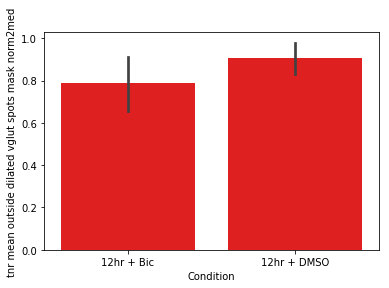

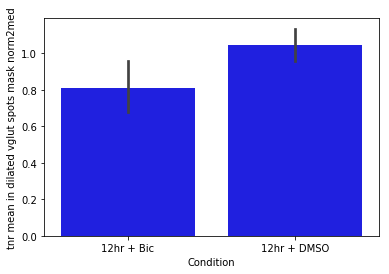

In [20]:
plt.figure()
sns.barplot(x="Condition",y="tnr mean outside dilated vglut spots mask norm2med",color='red',data=df3)
plt.figure()
sns.barplot(x="Condition",y="tnr mean in dilated vglut spots mask norm2med",color='blue',data=df3)

## Make a single datapoint for each exp

In [21]:
mean_by_exp={"exp name":[],"condition":[],"in or out dilated vglut mask":[],
             "mean tnr norm2unblockedmean":[],
             "mean tnr norm2med":[]}
for exp in df3["expname"].unique():
    dfexp=df3[df3["expname"]==exp]
    for condition in dfexp["Condition"].unique():
        dfexpcond=dfexp[dfexp["Condition"]==condition]
        
        mean_by_exp["exp name"].append(exp)
        mean_by_exp["condition"].append(condition)
        mean_by_exp["in or out dilated vglut mask"].append("At synapses")
        mean_by_exp["mean tnr norm2unblockedmean"].append(dfexpcond["tnr mean in dilated vglut spots mask norm2unblockedmean"].mean())
        mean_by_exp["mean tnr norm2med"].append(dfexpcond["tnr mean in dilated vglut spots mask norm2med"].mean())
        mean_by_exp["exp name"].append(exp)
        mean_by_exp["condition"].append(condition)
        mean_by_exp["in or out dilated vglut mask"].append("Outside synapses")
        mean_by_exp["mean tnr norm2unblockedmean"].append(dfexpcond["tnr mean outside dilated vglut spots mask norm2unblockedmean"].mean())
        mean_by_exp["mean tnr norm2med"].append(dfexpcond["tnr mean outside dilated vglut spots mask norm2med"].mean())
dfbyexp=pd.DataFrame(mean_by_exp)

In [22]:
dfbyexp["condition"].unique()

array(['12hr + Bic', '12hr + DMSO'], dtype=object)

([<matplotlib.axis.YTick at 0x12ebf4c88>,
 <a list of 3 Text yticklabel objects>)

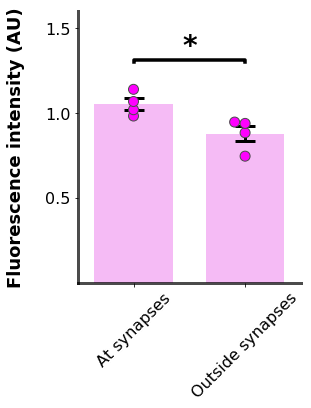

In [23]:
var="mean tnr norm2med"

df2plot=dfbyexp[(dfbyexp["condition"]=="12hr + DMSO")]#&(dfbyexp["exp name"]!="20190302_TNR647_Vglut580_DiO")]
plt.figure(figsize=(4,5))

g=sns.swarmplot(data=df2plot,x="in or out dilated vglut mask",y=var,
             size=10,color='magenta',linewidth=1)
g=sns.barplot(data=df2plot,x="in or out dilated vglut mask",y=var
              ,alpha=0.3,ci=None,color='magenta')
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        

change_width(g, .7)
plt.errorbar(x=[0,1],
             y=[df2plot[df2plot["in or out dilated vglut mask"]=="At synapses"][var].mean(),
                df2plot[df2plot["in or out dilated vglut mask"]=="Outside synapses"][var].mean()],
             yerr=[df2plot[df2plot["in or out dilated vglut mask"]=="At synapses"][var].sem(),
                df2plot[df2plot["in or out dilated vglut mask"]=="Outside synapses"][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3)


plt.ylim([0,1.5])
g.set_ylabel('Fluorescence intensity (AU)',size=18,weight ='bold',labelpad=20)
g.set_xlabel('',color='black',alpha=.7)
plt.xticks(g.get_xticks(),size=16,rotation=45)
plt.yticks(g.get_yticks(),size=16)
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

#plt.ylim([0/100,1/100])
#plt.xlim([-1,2])


x1, x2 = 0,1
y= 1.3
h=0.01*df2plot[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
plt.yticks([0.5,1,1.5])


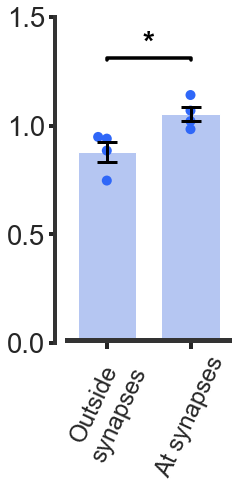

In [52]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker


var="mean tnr norm2med"

fig=plt.figure(figsize=(3,6))

order=["Outside synapses","At synapses"]

g=sns.swarmplot(data=df2plot,y=var,x="in or out dilated vglut mask",color="#2F67F8",order=order,size=10)

g=sns.barplot(data=df2plot,y=var,x="in or out dilated vglut mask"
            ,order=order,color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .7)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["in or out dilated vglut mask"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["in or out dilated vglut mask"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

'''plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["in or out dilated vglut mask"]==condtype][var].mean() for condtype in order],
             yerr=None,
             xerr=np.repeat(0.5, 5),ecolor='black',fmt='none',capsize=0,linewidth=3,
             capthick=30,zorder=10,
            alpha=1)'''
plt.axhline(0, color='#333333',alpha=1,linewidth=10)

#plt.axhline(negctrlmean, color='#333333',alpha=1,linewidth=5,linestyle='--')



g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),order,
           rotation=90,size=20)
plt.yticks([0,0.5,1,1.5],size=20,color='#333333')
g.grid(False)
plt.ylim([0,1.5])
#plt.xlim([-1,len(order)])

for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)



x1, x2 = 0,1
y= 1.3
h=.01
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')




offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)

plt.xticks(g.get_xticks(),['Outside\nsynapses','At synapses'], rotation=65,size=24)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp_newtnrepitopes_at_or_outside_synapses.svg', bbox_inches='tight', format='svg')





## Statistics to make sure

In [41]:
synapses=df2plot[df2plot["in or out dilated vglut mask"]=="At synapses"][var].dropna().values
outsidesynapses=df2plot[df2plot["in or out dilated vglut mask"]=="Outside synapses"][var].dropna().values

[stat,pval_2_4]=stats.ttest_ind(synapses, outsidesynapses)

print('pval: '+str(pval_2_4))

pval: 0.023533385761473846
